In [1]:
%matplotlib_svg
%init_sympy_printing
import pylab as pl
import numpy as np
from scipy import integrate
from scipy import optimize
import sympy

## 经典力学模拟

### 悬链线

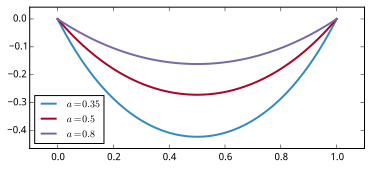

In [2]:
#%fig=各种长度的悬链线
def catenary(x, a):
    return a*np.cosh((x - 0.5)/a) - a*np.cosh((-0.5)/a)

x = np.linspace(0, 1, 100)
for a in [0.35, 0.5, 0.8]:
    pl.plot(x, catenary(x, a), label="$a={:g}$".format(a))
ax = pl.gca()
ax.set_aspect("equal")
ax.legend(loc="best")
pl.margins(0.1)

In [3]:
y = catenary(x, 0.35)
np.sqrt(np.diff(x)**2 + np.diff(y)**2).sum()

1.37655226488

In [4]:
from sympy import symbols, cosh, S, sqrt, lambdify
import sympy
x, a = symbols("x, a")
y = a * cosh((x - S(1)/2) / a)
s = sqrt(1 + y.diff(x)**2)
fs = lambdify((x, a), s, modules="math")

def catenary_length(a):
    return integrate.quad(lambda x:fs(x, a), 0, 1)[0]

length = catenary_length(0.35)
length

1.3765789965

#### 使用运动方程模拟悬链线

a = 0.336992602016 length = 1.40946777721


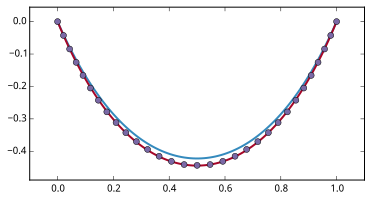

In [14]:
#%fig=使用运动方程模拟悬链线，由于弹簧会被拉伸，因此悬链线略比原始长度长
N = 31
dump = 0.2 #阻尼系数
k = 100.0  #弹簧系数
l = length / (N - 1) #弹簧原长度
g = 0.01 #重力加速度

x0 = np.linspace(0, 1, N)
y0 = np.zeros_like(x0)
vx0 = np.zeros_like(x0)
vy0 = np.zeros_like(x0)

def diff_status(status, t):
    x, y, vx, vy = status.reshape(4, -1)
    dvx = np.zeros_like(x)
    dvy = np.zeros_like(x)
    dx = vx
    dy = vy
    
    s = np.s_[1:-1]
    
    l1 = np.sqrt((x[s] - x[:-2])**2 + (y[s] - y[:-2])**2)
    l2 = np.sqrt((x[s] - x[2:])**2 + (y[s] - y[2:])**2)
    dl1 = (l1 - l) / l1
    dl2 = (l2 - l) / l2
    dvx[s] = -vx[s] * dump - (x[s] - x[:-2]) * k * dl1 - (x[s] - x[2:]) * k * dl2
    dvy[s] = -vy[s] * dump - (y[s] - y[:-2]) * k * dl1 - (y[s] - y[2:]) * k * dl2 + g
    return np.r_[dx, dy, dvx, dvy]

status0 = np.r_[x0, y0, vx0, vy0]

t = np.linspace(0, 50, 100)
r = integrate.odeint(diff_status, status0, t)
x, y, vx, vy = r[-1].reshape(4, -1)

r, e = optimize.curve_fit(catenary, x, -y, [1])
print(("a =", r[0], "length =", catenary_length(r[0])))

x2 = np.linspace(0, 1, 100)
pl.plot(x2, catenary(x2, 0.35))
pl.plot(x2, catenary(x2, r))
pl.plot(x, -y, "o")
pl.margins(0.1)

> **SOURCE**

> `scpy2.examples.catenary`：使用TraitsUI制作的悬链线的动画演示程序，可通过界面修改各个参数

In [15]:
#%hide
%exec_python -m scpy2.examples.catenary

#### 通过能量最小值计算悬链线

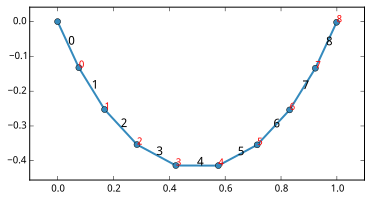

In [16]:
#%figonly=把悬链线分为多个质点并用无质量的连接杆相连
x = np.linspace(0, 1, 1000)
y = catenary(x, 0.35)
s = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
p = np.linspace(0, s[-1], 10)
idx = np.searchsorted(s, p)
x, y = x[idx], y[idx]
pl.plot(x, y, "-o", lw=2)
for i, (x1, x2, y1, y2) in enumerate(zip(x[:-1], x[1:], y[:-1], y[1:])):
    pl.text((x1+x2)*0.5, (y1+y2)*0.5, "%d" % i)
    pl.text(x2, y2, "%d" % i, color="r", fontsize=10)
pl.margins(0.1)

In [17]:
N = 30

l = length / N

def g1(theta):
    return np.sum(l * np.cos(theta)) - 1.0
    
def g2(theta):
    return np.sum(l * np.sin(theta)) - 0.0
    
def P(theta):
    y = l * np.sin(theta)
    cy = np.cumsum(y)
    return np.sum(cy)

theta0 = np.arccos(1.0 / length)
theta_init = [-theta0] * (N // 2) + [theta0] * (N // 2) #❶

theta = optimize.fmin_slsqp(P, theta_init, 
                            eqcons=[g1, g2], #❷
                            bounds=[(-np.pi/2, np.pi/2)]*N) #❸

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7.76529946378
            Iterations: 9
            Function evaluations: 288
            Gradient evaluations: 9


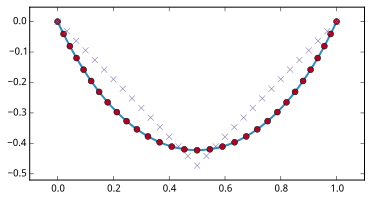

In [18]:
#%fig=使用fmin_slsqp()计算能量最低的状态，叉点表示最优化的初始状态
x_init = np.r_[0, np.cumsum(l * np.cos(theta_init))]
y_init = np.r_[0, np.cumsum(l * np.sin(theta_init))]

x = np.r_[0, np.cumsum(l * np.cos(theta))]
y = np.r_[0, np.cumsum(l * np.sin(theta))]

x2 = np.linspace(0, 1, 100)
pl.plot(x2, catenary(x2, 0.35))
pl.plot(x, y, "o")
pl.plot(x_init, y_init, "x")
pl.margins(0.1)

### 最速降线

In [3]:
x, _ = integrate.quad(lambda y:np.sqrt(y/(1.0-y)), 0, 1)
print(x)

1.57079632679


#### 使用odeint()计算最速降线

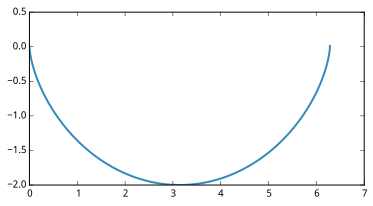

In [114]:
#%fig=使用odeint()计算最速降线
def brachistochrone_curve(D, N=1000):
    eps = 1e-8
    def f(y, x):
        y = min(max(eps, y), D) #❶        
        flag = -1 if x >= D * np.pi / 2 else 1 #❷
        return flag * ((D - y) / y) ** 0.5
    
    x0 = np.linspace(0, D * np.pi, N)
    y = integrate.odeint(f, 0, x0)
    return x0, y.ravel()

x, y = brachistochrone_curve(2.0)
pl.plot(x, -y);

#### 使用优化算法计算最速降线

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.53634462725
            Iterations: 72
            Function evaluations: 7370
            Gradient evaluations: 72


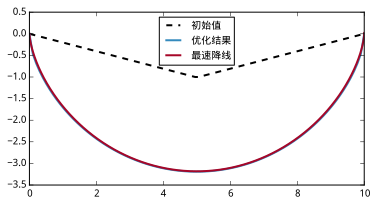

In [119]:
#%fig=使用优化算法计算最速降线
N = 100.0
target = 10.0
x = np.linspace(0, target, N)
tmp = np.linspace(0, -1, N // 2)
y0 = np.r_[tmp, tmp[::-1]]
g = 9.8

def total_time(y):
    s = np.hypot(np.diff(x), np.diff(y)) #❶
    v = np.sqrt(2 * g * np.abs(y)) #❷
    avg_v = np.maximum((v[1:] + v[:-1])*0.5, 1e-10) #❸
    t =  s / avg_v
    return t.sum()

def fix_two_ends(y):
    return y[[0, -1]]

y_opt = optimize.fmin_slsqp(total_time, y0, eqcons=[fix_two_ends]) #❹
pl.plot(x, y0, "k--", label="初始值")
pl.plot(x, y_opt, label="优化结果")
x2, y2 = brachistochrone_curve(target / np.pi)
pl.plot(x2, -y2, label="最速降线")
pl.legend(loc="best");

### 单摆模拟

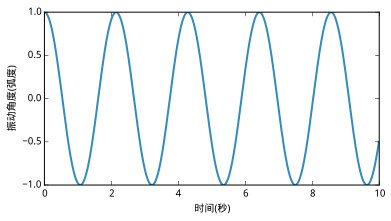

In [5]:
#%fig=初始角度为1弧度的单摆摆动角度和时间的关系
from math import sin

g = 9.8

def pendulum_equations(w, t, l):
    th, v = w
    dth = v
    dv  = - g / l * sin(th)
    return dth, dv
    
t = np.arange(0, 10, 0.01)
track = integrate.odeint(pendulum_equations, (1.0, 0), t, args=(1.0,))
pl.plot(t, track[:, 0])
pl.xlabel("时间(秒)")
pl.ylabel("振动角度(弧度)");

####小角度时的摆动周期 

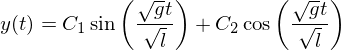

In [130]:
from sympy import symbols, Function, dsolve
t, g, l = symbols("t,g,l", positive=True) # 分别表示时间、重力加速度和长度
y = Function("y") # 摆角函数用y(t)表示
dsolve(y(t).diff(t,2) + g/l*y(t), y(t))    

#### 大角度时的摆动周期

In [6]:
g = 9.8

def pendulum_th(t, l, th0):
    track = integrate.odeint(pendulum_equations, (th0, 0), [0, t], args=(l,))
    return track[-1, 0]
    
def pendulum_period(l, th0):
    t0 = 2*np.pi*(l / g)**0.5 / 4
    t = fsolve( pendulum_th, t0, args = (l, th0) )
    return t*4

In [7]:
def pendulum_th(t, l, th0):
    track = integrate.odeint(pendulum_equations, (th0, 0), [0, t], args=(l,))
    return track[-1, 0]

In [8]:
from scipy.optimize import fsolve

def pendulum_period(l, th0):
    t0 = 2*np.pi*(l / g)**0.5 / 4
    t = fsolve(pendulum_th, t0, args = (l, th0))
    return t * 4

In [9]:
ths = np.arange(0, np.pi/2.0, 0.01)
periods = [pendulum_period(1, th) for th in ths]

In [10]:
from scipy.special import ellipk
periods2 = 4 * (1.0 / g)**0.5 * ellipk(np.sin(ths / 2) **2 ) 

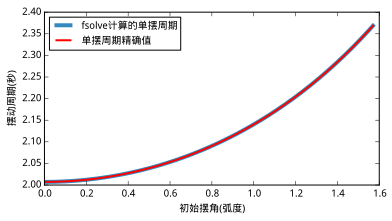

In [11]:
#%fig=单摆的摆动周期和初始角度的关系    
ths = np.arange(0, np.pi/2.0, 0.01)
periods = [pendulum_period(1, th) for th in ths]
periods2 = 4 * (1.0/g)**0.5 *ellipk(np.sin(ths/2)**2) # 计算单摆周期的精确值
pl.plot(ths, periods, label = "fsolve计算的单摆周期", linewidth=4.0)
pl.plot(ths, periods2, "r", label = "单摆周期精确值", linewidth=2.0)
pl.legend(loc='upper left')
pl.xlabel("初始摆角(弧度)")
pl.ylabel("摆动周期(秒)");